In [3]:
import cv2
from enum import Enum
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt 
import matplotlib.patches as patches
import json
import os
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
import torch

import openpifpaf

class VehicleType(Enum):
    SEDAN = 1
    SUV = 2

class Vehicle:
    def __init__(self):
        self.segment = 0
        self.segment_mask = 0
        self.rcnn_mask = 0
        self.original_mask = 0
        self.original_box = 0

        self.expanded_box = np.array([],dtype="int")
        self.box_shape = (0,0)
        
        self.resized = False
        self.resized_shape = (0,0)
        self.resized_segment = 0
        self.resized_segment_mask = 0
        
        self.keypoints = []
        self.keypoints_resized = []
        self.keypoints_id = []
        self.no_keypoints = False

        self.transfrom = (0,0)

        self.type = VehicleType.SEDAN

        self.water_level = 0.0

        self.ground_truth_waterlevel = 0.0

In [4]:
max_square_size_list = [512,384,256,192,128] # 256 128
apply_mask = False

kpt_outliers = [58,59,60,61,62,63,64,65]
# kpt_outliers = []
kpt_inliers = []

CppCifCaf = torch.classes.openpifpaf_decoder.CifCaf
# CppCifCaf.set_force_complete(True)
CppCifCaf.set_keypoint_threshold(0.0)
Keypoints = torch.classes.openpifpaf_decoder_utils.NMSKeypoints
Keypoints.set_instance_threshold(0.00)
Keypoints.set_keypoint_threshold(0.00)

predictor = openpifpaf.Predictor(checkpoint='shufflenetv2k30-apollo-66')
kpt_amount = 66

In [21]:
def get_cars(np_image,cars_data):
    im_height, im_width, _ =np_image.shape
    cars = []
    car_amount = len(cars_data)
    for car_data in cars_data:
        # data acquiation
        box = np.array(car_data["box"])
        mask = np.array(car_data["mask"])

        # get size
        x1 = box[0]
        y1 = box[1]
        x2 = box[2]
        y2 = box[3]
        box_width = x2 - x1
        box_height = y2 - y1
        
        
        # expand the box and cut
        width_increment = 0.2*box_width
        height_increment = 0.2*box_height
        new_x1 = int(max(x1 - width_increment,0))
        new_y1 = int(max(y1 - height_increment,0))
        new_x2 = int(min(x2 + width_increment,im_width))
        new_y2 = int(min(y2 + height_increment,im_height))
        new_box_width = new_x2 - new_x1
        new_box_height = new_y2 - new_y1

        new_box = np.array([new_x1,new_y1,new_x2,new_y2],dtype="int")

        new_segment = np_image[new_y1:new_y2,new_x1:new_x2]

        # do the mask
        mask_seg = mask[new_y1:new_y2,new_x1:new_x2]

        vehicle = Vehicle()
        vehicle.rcnn_mask = mask
        vehicle.original_box = box
        vehicle.original_mask = mask
        vehicle.expanded_box = new_box
        vehicle.box_shape = (new_box_width,new_box_height)
        vehicle.segment = new_segment
        vehicle.segment_mask = mask_seg
        
        cars.append(vehicle)
    return cars

def resize_car(car,max_square_size):
    (new_box_width,new_box_height) = car.box_shape
    new_segment = car.segment
    mask_seg = car.segment_mask
    max_length = max(new_box_width,new_box_height)
    if max_length > max_square_size:
        ratio = max_square_size / max_length
        resized_width = int(new_box_width * ratio)
        resized_height = int(new_box_height * ratio)
        car.resized_segment = cv2.resize(new_segment,(resized_width,resized_height),interpolation = cv2.INTER_AREA)
        car.resized_segment_mask = cv2.resize(mask_seg,(resized_width,resized_height),interpolation = cv2.INTER_AREA)
        car.resized = True
        car.resized_shape = (resized_width,resized_height)
    else:
        car.resized = False
        car.resized_segment = new_segment
        car.resized_segment_mask = mask_seg
    return car.resized

def apply_mask(car):
    mask_3 = np.expand_dims(car.resized_segment_mask, axis=2)
    mask_3 = np.concatenate((mask_3, mask_3, mask_3), axis=-1)
    car.resized_segment = np.where(mask_3, car.resized_segment, 0)

def detect_keypoints(car):
    predictions, gt_anns, image_meta = predictor.numpy_image(car.resized_segment)
    visable_index = []
    visable_keypoints_2D = []
    visable_scores = []
    
    if len(predictions)==0:
        return visable_index,visable_keypoints_2D,visable_scores  
        
    keypoints = predictions[0].data.tolist()
        
    

    for i in range(0,kpt_amount):
        if i in kpt_outliers:
            continue

        x = keypoints[i][0]
        y = keypoints[i][1]
        score = keypoints[i][2]
        if(score > 0.0):
            visable_index.append(i)
            visable_keypoints_2D.append([x,y])
            visable_scores.append(score)

    return visable_index,visable_keypoints_2D,visable_scores

def recover_keypoint(keypoint,original_shape,resized_shape,x_offset,y_offest):
    x = keypoint[0]
    y = keypoint[1]
    resized_width, resized_height = resized_shape
    box_width, box_height = original_shape
    x_ratio = x / resized_width
    y_ratio = y / resized_height
    recovered_x = box_width * x_ratio + x_offset
    recovered_y = box_height * y_ratio + y_offest
    recovered_keypoints_2D = [recovered_x,recovered_y]
    return recovered_keypoints_2D

def show_keypoint(image,keypoints,folder,image_name):
    fig = plt.figure(figsize=(8,8))
    plt.axis('off')
    for kpt_id, kpt in zip(keypoints[0],keypoints[1]):
        plt.scatter(int(kpt[0]),int(kpt[1]),c='coral', s=10)
        plt.text(int(kpt[0]), int(kpt[1]), str(kpt_id),color = "ivory",fontsize=10)
    plt.imshow(image)
    # plt.show()
    plt.savefig(folder+image_name,bbox_inches='tight',dpi=200,pad_inches=0.0)
    plt.close()

def show_keypoint_score(image,keypoints,folder,image_name):
    fig = plt.figure(figsize=(8,8))
    plt.axis('off')
    for kpt_id, kpt, score in zip(keypoints[0],keypoints[1],keypoints[2]):
        plt.scatter(int(kpt[0]),int(kpt[1]),c='coral', s=10)
        plt.text(int(kpt[0]), int(kpt[1]), f"{kpt_id} {round(score,2)}",color = "red",fontsize=5)
    plt.imshow(image)
    # plt.show()
    plt.savefig(folder+image_name,bbox_inches='tight',dpi=200,pad_inches=0.0)
    plt.close()

def merge_keypoint(car,merge_kpts,new_kpts):
    merged_kpt_id,merged_kpt,merged_score = merge_kpts
    kpt_id,kpts,kpts_score = new_kpts

    kernel = np.ones((30,30),np.uint8) 
    big_mask = cv2.dilate(car.resized_segment_mask,kernel,iterations = 1)

    recovered_kpts = []
    for i in range(0,len(kpts)):
        if big_mask[round(kpts[i][1]),round(kpts[i][0])] == 0:
            continue
        if kpt_id[i] not in merged_kpt_id:
            merged_kpt_id.append(kpt_id[i])
            merged_score.append(kpts_score[i])
            if car.resized:
                re_kpt = recover_keypoint(kpts[i],car.box_shape,car.resized_shape,car.expanded_box[0],car.expanded_box[1])
                recovered_kpts.append(re_kpt)
                merged_kpt.append(re_kpt)
            else:
                re_kpt = recover_keypoint(kpts[i],car.box_shape,car.box_shape,car.expanded_box[0],car.expanded_box[1])
                recovered_kpts.append(re_kpt)
                merged_kpt.append(re_kpt)
        else:
            merged_index = merged_kpt_id.index(kpt_id[i])
            old_score = merged_score[merged_index]
            if kpts_score[i] > old_score:
                merged_score[merged_index] = kpts_score[i]
                if car.resized:
                    re_kpt = recover_keypoint(kpts[i],car.box_shape,car.resized_shape,car.expanded_box[0],car.expanded_box[1])
                    recovered_kpts.append(re_kpt)
                    merged_kpt[merged_index] = re_kpt
                else:
                    re_kpt = recover_keypoint(kpts[i],car.box_shape,car.box_shape,car.expanded_box[0],car.expanded_box[1])
                    recovered_kpts.append(re_kpt)
                    merged_kpt[merged_index] = re_kpt
    return recovered_kpts

In [25]:
image_folder = "../images/Flood/"
keypoint_result_folder = "../result_keypoint/"
mask_result_folder = "../result_mask/"

file_names = os.listdir(image_folder)
for image_name in file_names:
# image_name = file_names[0]
    base_name = os.path.splitext(image_name)[0]
    single_folder = keypoint_result_folder+base_name+"/"
    if not os.path.exists(single_folder):
        os.makedirs(single_folder)
    text_record = open(single_folder+base_name+".txt","w")
    label_name = base_name+".json"

    pil_image = Image.open(image_folder+image_name)
    im_width, im_height = pil_image.size
    np_image = np.array(pil_image)

    with open(mask_result_folder+label_name) as json_file:
        data = json.load(json_file)
        cars_data = data["cars"]

    cars = get_cars(np_image,cars_data)
    for id,car in enumerate(cars):
        text_record.write(f"car {id}\n")

        results = []
        merged_kpt_id = []
        merged_kpt = []
        merged_score = []
        
        for square_size in max_square_size_list:
            resize_car(car,square_size)
            kpt_id,kpts,kpts_score = detect_keypoints(car)
            recovered_kpts = merge_keypoint(car,(merged_kpt_id,merged_kpt,merged_score),(kpt_id,kpts,kpts_score))
            fig = plt.figure(figsize=(8,8))
            plt.axis('off')
            
            for kpt_id, kpt, score in zip(kpt_id,kpts,kpts_score):
                plt.scatter(int(kpt[0]),int(kpt[1]),c='coral', s=10)
                plt.text(int(kpt[0]), int(kpt[1]), f"{kpt_id} {round(score,2)}",color = "red",fontsize=10)
            plt.imshow(car.resized_segment)   
            plt.savefig(single_folder+base_name+f"_car_{id}_{square_size}.jpg",bbox_inches='tight',dpi=fig.dpi,pad_inches=0.0)
            plt.close() 
        #     recovered_kpts = []
        #     for i in range(0,len(kpts)):
        #         if kpt_id[i] not in merged_kpt_id:
        #             merged_kpt_id.append(kpt_id[i])
        #             if car.resized:
        #                 re_kpt = recover_keypoint(kpts[i],car.box_shape,car.resized_shape,car.expanded_box[0],car.expanded_box[1])
        #                 recovered_kpts.append(re_kpt)
        #                 merged_kpt.append(re_kpt)
        #             else:
        #                 re_kpt = recover_keypoint(kpts[i],car.box_shape,car.box_shape,car.expanded_box[0],car.expanded_box[1])
        #                 recovered_kpts.append(re_kpt)
        #                 merged_kpt.append(re_kpt)
        #     # results.append()
        #     # if kpt_no_mask[0]:
        #     show_keypoint_score(car.resized_segment,(kpt_id,kpts,kpts_score),single_folder,base_name+f"_car_{id}_{square_size}.jpg")
            apply_mask(car)
            kpt_id_mask,kpts_mask,kpts_score_mask = detect_keypoints(car)
            recovered_kpts_mask = merge_keypoint(car,(merged_kpt_id,merged_kpt,merged_score),(kpt_id_mask,kpts_mask,kpts_score_mask))
        #     for i in range(0,len(kpts_mask)):
        #         if kpt_id_mask[i] not in merged_kpt_id:
        #             merged_kpt_id.append(kpt_id_mask[i])
        #             if car.resized:
        #                 re_kpt = recover_keypoint(kpts_mask[i],car.box_shape,car.resized_shape,car.expanded_box[0],car.expanded_box[1])
        #                 recovered_kpts_mask.append(re_kpt)
        #                 merged_kpt.append(re_kpt)
        #             else:
        #                 re_kpt = recover_keypoint(kpts_mask[i],car.box_shape,car.box_shape,car.expanded_box[0],car.expanded_box[1])
        #                 recovered_kpts_mask.append(re_kpt)
        #                 merged_kpt.append(re_kpt)
        #     # if kpt_with_mask[0]:
        #     show_keypoint_score(car.resized_segment,(kpt_id,kpts_mask,kpts_score_mask),single_folder,base_name+f"_car_{id}_{square_size}_mask.jpg")
            fig = plt.figure(figsize=(8,8))
            plt.axis('off')

            for kpt_id, kpt, score in zip(kpt_id_mask,kpts_mask,kpts_score_mask):
                plt.scatter(int(kpt[0]),int(kpt[1]),c='coral', s=10)
                plt.text(int(kpt[0]), int(kpt[1]), f"{kpt_id} {round(score,2)}",color = "red",fontsize=10)
            plt.imshow(car.resized_segment)   
            plt.savefig(single_folder+base_name+f"_car_{id}_{square_size}_mask.jpg",bbox_inches='tight',dpi=fig.dpi,pad_inches=0.0)
            plt.close() 
        show_keypoint(np_image,(merged_kpt_id,merged_kpt),single_folder,base_name+f"_car_{id}.jpg")

        if len(merged_kpt) < 3:
            text_record.write("no keypoint\n")
            car.no_keypoints = True
        else:
            text_record.write(f"with {len(merged_kpt)} keypoints\n")
            car.keypoints_id = merged_kpt_id
            car.keypoints = merged_kpt

    valid_cars = [car for car in cars if not car.no_keypoints]

    keypoints_data = {"cars":[]}
    for car in valid_cars:
        keypoints_data["cars"].append({
            "box":car.original_box.tolist(),
            "mask":car.original_mask.tolist(),
            "keypoint":car.keypoints,
            "keypoint_id":car.keypoints_id
        })

    with open(single_folder+base_name+".json","w") as file:
        file.write(json.dumps(keypoints_data))

    car_amount = len(valid_cars)
    text_record.write(f"valid cars amount:{car_amount}")
    if car_amount > 0:
        fig = plt.figure(figsize=(8,8))
        plt.axis('off')
        for i,car in enumerate(valid_cars):
            for kpt_id, kpt in zip(car.keypoints_id,car.keypoints):
                plt.scatter(int(kpt[0]),int(kpt[1]),c='coral', s=10)
                plt.text(int(kpt[0]), int(kpt[1]), str(kpt_id),color = "ivory",fontsize=10)
        plt.imshow(np_image)   
        plt.savefig(single_folder+image_name,bbox_inches='tight',dpi=fig.dpi,pad_inches=0.0)
        plt.close() 
    else:
        Image.fromarray(np_image).save(single_folder+image_name)
    text_record.close()


In [22]:
image_folder = "../images/Flood/"
keypoint_result_folder = "../result_keypoint/"
mask_result_folder = "../result_mask/"


image_name = "Flood_1331.jpg"
base_name = os.path.splitext(image_name)[0]
label_name = base_name+".json"

pil_image = Image.open(image_folder+image_name)
im_width, im_height = pil_image.size
np_image = np.array(pil_image)

single_folder = keypoint_result_folder+base_name+"/"
if not os.path.exists(single_folder):
    os.makedirs(single_folder)

with open(mask_result_folder+label_name) as json_file:
    data = json.load(json_file)
    cars_data = data["cars"]

cars = get_cars(np_image,cars_data)

for id,car in enumerate(cars):
    results = []
    merged_kpt_id = []
    merged_kpt = []
    merged_score = []
    for square_size in max_square_size_list:
        resize_car(car,square_size)
        kpt_id,kpts,kpts_score = detect_keypoints(car)
        recovered_kpts = merge_keypoint(car,(merged_kpt_id,merged_kpt,merged_score),(kpt_id,kpts,kpts_score))

        # show_keypoint(car.resized_segment,(kpt_id,kpts),single_folder,base_name+f"_car_{id}_{square_size}.jpg")
        fig = plt.figure(figsize=(8,8))
        plt.axis('off')
        
        for kpt_id, kpt, score in zip(kpt_id,kpts,kpts_score):
            plt.scatter(int(kpt[0]),int(kpt[1]),c='coral', s=10)
            plt.text(int(kpt[0]), int(kpt[1]), f"{kpt_id} {round(score,2)}",color = "red",fontsize=10)
        plt.imshow(car.resized_segment)   
        plt.savefig(single_folder+base_name+f"_car_{id}_{square_size}.jpg",bbox_inches='tight',dpi=fig.dpi,pad_inches=0.0)
        plt.close() 

        apply_mask(car)
        kpt_id_mask,kpts_mask,kpts_score_mask = detect_keypoints(car)
        recovered_kpts_mask = merge_keypoint(car,(merged_kpt_id,merged_kpt,merged_score),(kpt_id_mask,kpts_mask,kpts_score_mask))
        # if kpt_with_mask[0]:
        # show_keypoint(car.resized_segment,(kpt_id,kpts_mask),single_folder,base_name+f"_car_{id}_{square_size}_mask.jpg")
        fig = plt.figure(figsize=(8,8))
        plt.axis('off')

        for kpt_id, kpt, score in zip(kpt_id_mask,kpts_mask,kpts_score_mask):
            plt.scatter(int(kpt[0]),int(kpt[1]),c='coral', s=10)
            plt.text(int(kpt[0]), int(kpt[1]), f"{kpt_id} {round(score,2)}",color = "red",fontsize=10)
        plt.imshow(car.resized_segment)   
        plt.savefig(single_folder+base_name+f"_car_{id}_{square_size}_mask.jpg",bbox_inches='tight',dpi=fig.dpi,pad_inches=0.0)
        plt.close() 

    if len(merged_kpt) < 3:
        print("no keypoint\n")
        car.no_keypoints = True
    else:
        print(f"with {len(merged_kpt)} keypoints\n")
        car.keypoints_id = merged_kpt_id
        car.keypoints = merged_kpt

valid_cars = [car for car in cars if not car.no_keypoints]

keypoints_data = {"cars":[]}
for car in valid_cars:
    keypoints_data["cars"].append({
        "box":car.original_box.tolist(),
        "mask":car.original_mask.tolist(),
        "keypoint":car.keypoints,
        "keypoint_id":car.keypoints_id
    })

with open(single_folder+base_name+".json","w") as file:
    file.write(json.dumps(keypoints_data))

show_keypoint_score(np_image,(merged_kpt_id,merged_kpt,merged_score),single_folder,base_name+f"_car_{id}.jpg")

# if len(merged_kpt) < 3:
#     text_record.write("no keypoint\n")
#     car.no_keypoints = True
# else:
#     text_record.write(f"with {len(merged_kpt)} keypoints\n")
#     car.keypoints_id = merged_kpt_id
#     car.keypoints = merged_kpt
# resize_car(car,128)
# has_keypoint,kpt_num,kpts = detect_keypoints(car)

with 24 keypoints

with 24 keypoints



NameError: name 'text_record' is not defined

TypeError: Invalid shape () for image data

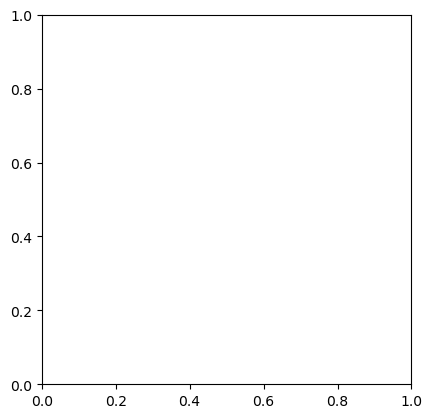

In [14]:
plt.figure()
plt.imshow(cars[1].resized_segment_mask)
plt.show()

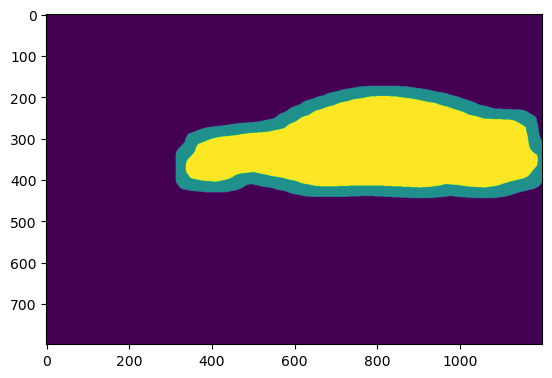

In [10]:
kernel = np.ones((30,30),np.uint8) 
dilation = cv2.dilate(cars[1].original_mask,kernel,iterations = 1)

plt.figure()
plt.imshow(dilation+cars[1].original_mask)
plt.show()

In [ ]:
%matplotlib widget
kpt_id,kpt_resized,kpt_original = kpts
fig = plt.figure(figsize=(8,8))
# plt.axis('off')
for kpt_id, kpt in zip(kpt_id,kpt_resized):
    plt.scatter(int(kpt[0]),int(kpt[1]),c='coral', s=10)
    plt.text(int(kpt[0]), int(kpt[1]), str(kpt_id),color = "ivory",fontsize=10)
plt.imshow(car.resized_segment)
plt.show()